In [6]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os

In [7]:
# Defining Preprocessed dataset
data_path = "..\data\preprocessed dataset"
model_path = "..\models"

In [8]:
# Load test dataset
X_test = pd.read_csv(os.path.join(data_path, "X_test.csv"))
y_test = pd.read_csv(os.path.join(data_path, "y_test.csv"))

# Load trained models
rf_model = joblib.load(os.path.join(model_path, "random_forest_model.pkl"))  # Load RF
xgb_model = joblib.load(os.path.join(model_path, "xgboost_model.pkl"))  # Load XGB

print("Models & Test Data Loaded Successfully!")

Models & Test Data Loaded Successfully!


In [9]:
# Initializing the SHAP explainer for Random Forest
explainer_rf = shap.Explainer(rf_model, X_test)
shap_values_rf = explainer_rf(X_test)

print("SHAP Explainer Initialized for Random Forest!")

100%|===================| 11997/12000 [21:46<00:00]        

SHAP Explainer Initialized for Random Forest!


In [11]:
print(X_test.columns)
print(shap_values_rf.shape)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'BILL_MEAN'],
      dtype='object')
(6000, 18, 2)


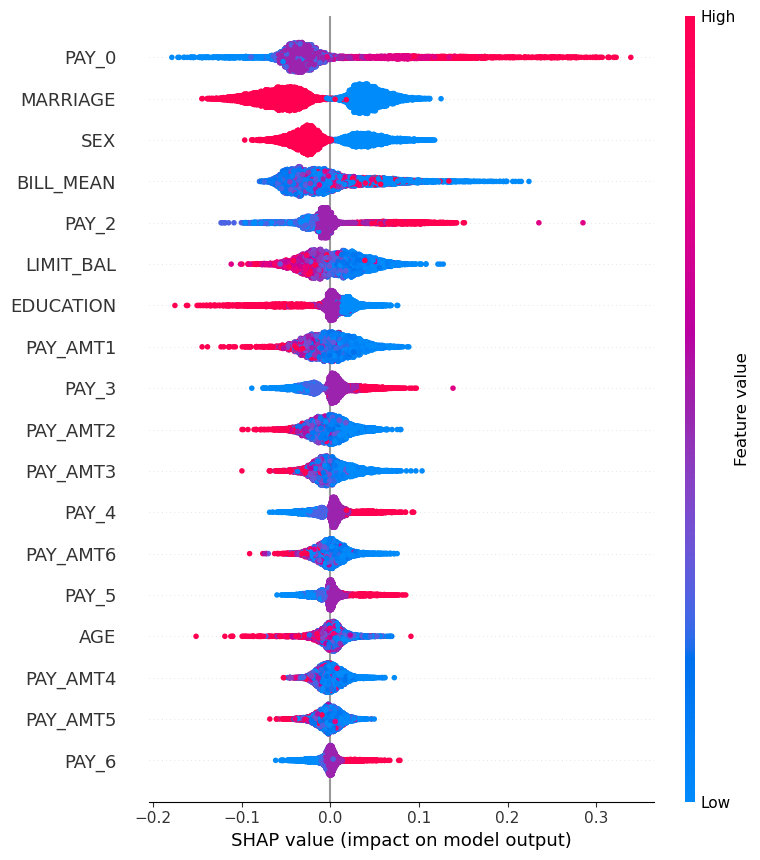

In [12]:
shap.summary_plot(shap_values_rf[..., 1], X_test)

Observations:
- `PAY_0` is the strongest predictor - Means if a customer miss their last payment, they're highly like to default
- `Marriage`, `Gender`, and `Bill_Mean`also have an impact - Marital status & gender might affect repayment behavior, and higher bill amounts could indicate financial stress
- `Higher credit limits (LIMIT_BAL)` reduce default risk, while lower limits increase it
- PAY_AMT features (past payment amounts) show some influence but are not as strong as PAY_0

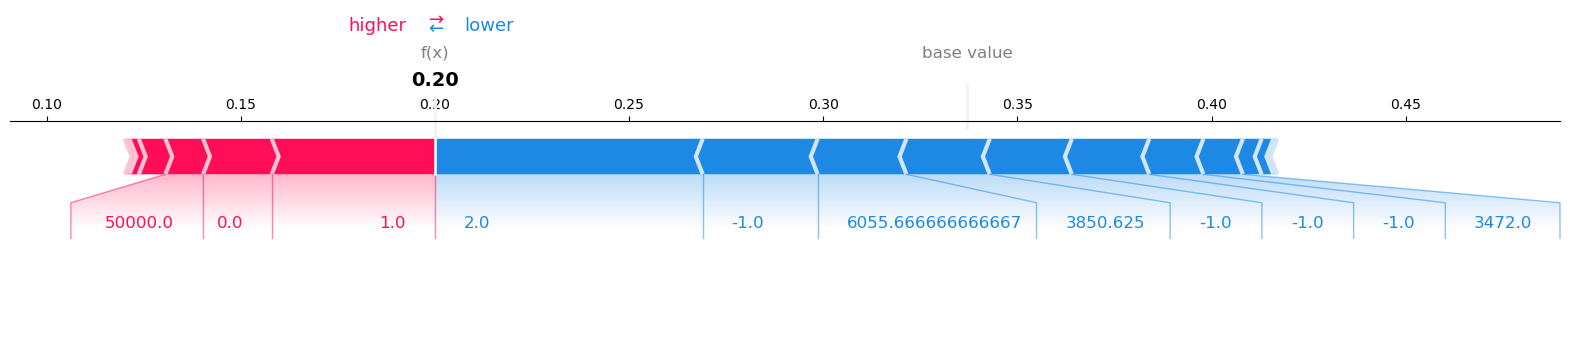

In [25]:
# Generating a SHAP force plot for a single customer in X_test

# Selecting a single customer
customer_index = 0

# Converting SHAP explanation format
shap_explanation = shap.Explanation(
    values = shap_values_rf[customer_index, :, 1],
    base_values = explainer_rf.expected_value[1],
    data = X_test.iloc[customer_index, :],
    feature_names = X_test.columns
)

# Generating the SHAP force plot for this customer
shap.initjs()
shap.force_plot(shap_explanation.base_values, shap_explanation.values, shap_explanation.data, matplotlib=True)

In [26]:
shap_explanation = shap.Explanation(
    values = shap_values_rf[customer_index, :, 1],  
    base_values = explainer_rf.expected_value[1],  
    data = X_test.iloc[customer_index, :],  
    feature_names = X_test.columns  
)

In [28]:
import pandas as pd

# Creating a Dataframe to display feature names, values, and SHAP impact
shap_df = pd.DataFrame({
    'Feature': X_test.columns,  #Feature names
    'Value': shap_explanation.data,   # Feature values for this customer
    'SHAP Impact': shap_explanation.values  # SHAP values(impact on prediction)
})

# Sorting by absolute SHAP Impace to see most imporatant features first
shap_df = shap_df.reindex(shap_df['SHAP Impact'].abs().sort_values(ascending = False).index)

print(shap_df)

      Feature         Value  SHAP Impact
3    MARRIAGE      2.000000    -0.068951
1         SEX      1.000000     0.042025
6       PAY_2     -1.000000    -0.029597
17  BILL_MEAN   6055.666667    -0.022859
11   PAY_AMT1   3850.625000    -0.021462
8       PAY_4     -1.000000    -0.021130
5       PAY_0     -1.000000    -0.019943
12   PAY_AMT2      0.000000     0.017686
7       PAY_3     -1.000000    -0.013944
13   PAY_AMT3   3472.000000    -0.010161
0   LIMIT_BAL  50000.000000     0.009714
2   EDUCATION      2.000000     0.006830
4         AGE     46.000000    -0.004823
16   PAY_AMT6   2841.000000    -0.003010
10      PAY_6      0.000000     0.002395
9       PAY_5      0.000000     0.001084
15   PAY_AMT5   1764.000000    -0.001034
14   PAY_AMT4   2320.000000     0.000099


In [31]:
# Printing the final risk category for the above customer prediction
import numpy as np

log_odds = shap_explanation.base_values + shap_explanation.values.sum()
prediction_prob = 1 / (1 + np.exp(-log_odds))   # Convert log-odds to probability

# Print the computed probability
print(f"\nFinal Predicted Probability: {prediction_prob:.4f}")

if prediction_prob < 0.3:
    risk_category = "Low Risk"
elif 0.3 <= prediction_prob < 0.6:
    risk_category = "Medium Risk"
else:
    risk_category = "High Risk"

print("\nFinal Risk Category:", risk_category)


Final Predicted Probability: 0.5498

Final Risk Category: Medium Risk


In [32]:
shap_explanation = shap.Explanation(
    values = shap_values_rf[customer_index, :, 1],  
    base_values = explainer_rf.expected_value[1],  # Check if this is correct
    data = X_test.iloc[customer_index, :],  
    feature_names = X_test.columns  
)

print(f"Expected Base Value (Class 1): {explainer_rf.expected_value[1]}")

Expected Base Value (Class 1): 0.33708181818181837


In [34]:
# Printing the intermediate log-odds calculation

print(f"Base Value (Log-Odds): {shap_explanation.base_values:.4f}")
print(f"Total SHAP Impact Sum (Log-Odds): {shap_explanation.values.sum():.4f}")
print(f"Final Log-Odds: {log_odds:.4f}")

Base Value (Log-Odds): 0.3371
Total SHAP Impact Sum (Log-Odds): -0.1371
Final Log-Odds: 0.2000


In [35]:
print(f"Converted Probability: {prediction_prob:.4f}")

Converted Probability: 0.5498


Observations:
- Base Value (Log-Odds): 0.3371 -> Average log-odds for Class 1(default) across all data, the model leans more towards predicting default
- Total SHAP Impact Sum (Log-Odds): -0.1371 -> SHAP values from this customer's features reduce the base log-odds, model considers them as less risky than the average
- Final Log-Odds: 0.2000 -> this is lower than the base value coz the SHAP impact was -ve, model adjusted its prediction downward for this customer
- Converted Probability: 0.5498 -> Log-odds 0.2000 converted using the sigmoid function gives 54.98% probability of default, this falls in the 0.3 - 0.6 range, the customer is categorized as Medium Risk

   Customer Index  Predicted Probability Risk Category
0               0               0.549834   Medium Risk
1               1               0.517493   Medium Risk
2               2               0.571996   Medium Risk
3               3               0.562177   Medium Risk
4               4               0.537430   Medium Risk


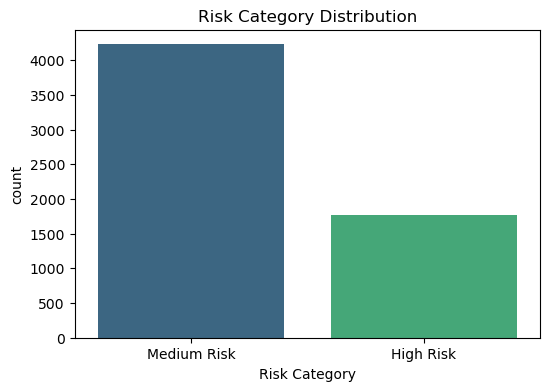

In [40]:
# Computing risk categories for all predictions
import numpy as np
import pandas as pd

# Empty list to store the results
risk_results = []

# Loop through all the customers in X_test
for i in range(len(X_test)):
    # Getting SHAP explanation for this customer
    shap_explanation = shap.Explanation(
        values = shap_values_rf[i, :, 1],
        base_values = explainer_rf.expected_value[1],
        data = X_test.iloc[i, :],
        feature_names = X_test.columns
    )

    # Compute log-odds
    log_odds = shap_explanation.base_values + shap_explanation.values.sum()

    # Convert log-odds to probability
    prediction_prob = 1 / (1 + np.exp(-log_odds))

    # Assign risk category
    if prediction_prob < 0.3:
        risk_category = "Low Risk"
    elif 0.3 <= prediction_prob < 0.6:
        risk_category = "Medium Risk"
    else:
        risk_category = "High Risk"
    
    # Append to results list
    risk_results.append([i, prediction_prob, risk_category])

# Convert to Dataframe
risk_predictions_df = pd.DataFrame(risk_results, columns = ["Customer Index", "Predicted Probability", "Risk Category"])

# Sample display
print(risk_predictions_df.head())

# Visualize risk distribution
import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize = (6, 4))
sns.countplot(data = risk_predictions_df, x = "Risk Category", palette = "viridis", hue = "Risk Category", legend = False)
plt.title("Risk Category Distribution")
plt.show()

Observations:
- Most customers are classified as `Medium Risk` ~4200+ customers
- Fewer customers are in the `High Risk` category ~1800 customers
- No `Low Risk` customers appear in the plot

Risk Category
Medium Risk    4230
High Risk      1770
Name: count, dtype: int64


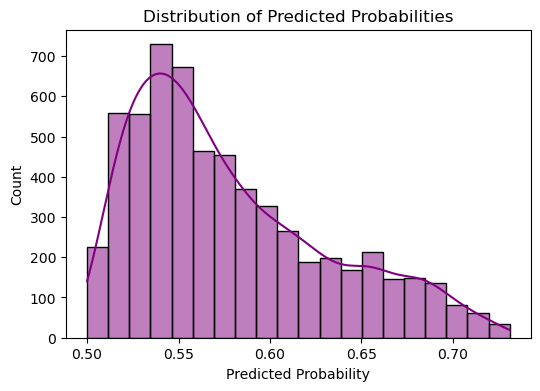

In [45]:
# Assign risk category with corrected labels
if prediction_prob < 0.3:
    risk_category = "Low Risk"   # Ensure "Low Risk" is assigned properly
elif 0.3 <= prediction_prob < 0.6:
    risk_category = "Medium Risk"
else:
    risk_category = "High Risk"  # Fix the typo here

# Check counts
print(risk_predictions_df["Risk Category"].value_counts())

# Visualize probability distribution
plt.figure(figsize=(6,4))
sns.histplot(risk_predictions_df["Predicted Probability"], bins=20, kde=True, color="purple")
plt.title("Distribution of Predicted Probabilities")
plt.show()

In [47]:
print("Min Probability:", risk_predictions_df["Predicted Probability"].min())
print("Max Probability:", risk_predictions_df["Predicted Probability"].max())

Min Probability: 0.4999999993534944
Max Probability: 0.7310585801635565


Observations:
- Min Probability: 0.5 and Max Probability: 0.73 -> entire probability range is between 0.5 - 0.73 so there are no 'Low Risk' category
- Most probabilities cluster around 0.50 to 0.55, model does not predict any extremely low risk cases

Action:
- Instead of just checking if any predicted probabilities fall below 0.3 - comparing the predictions with the actual labels y_test


In [52]:
# Checking for any low-risk customers in the dataset
print(y_test.value_counts(normalize = True))

default_payment_next_month
0                             0.778833
1                             0.221167
Name: proportion, dtype: float64


Observations:
- 77.88% of customers did not default means this could be Low/Medium Risk Category
- 22.11% of customers defaulted means High Risk Category

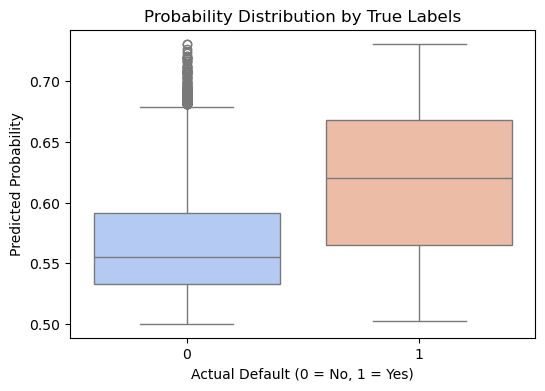

In [55]:
# Checking predicted probabilities align with actual defaults
import matplotlib.pyplot as plt
import seaborn as sns

# Converting (6000, 1) Dataframe to (6000,) series
y_test_series = y_test.squeeze()

plt.figure(figsize=(6,4))
sns.boxplot(x = y_test_series, y = risk_predictions_df["Predicted Probability"], palette = "coolwarm", hue = y_test_series, legend = False)
plt.xlabel("Actual Default (0 = No, 1 = Yes)")
plt.ylabel("Predicted Probability")
plt.title("Probability Distribution by True Labels")
plt.show()

Observations:
- x-axis: 0 = No Default, 1 = Default -> Median probability for default =1 is higher than the No Default = 0
- non-defaulters (0) have a high range of probabilities extending above 0.6 - many "safe" customers are getting risky probability scores

In [56]:
# Confusion Matrix to see the model misclassifies risk level
from sklearn.metrics import confusion_matrix

# Convert probability predictions to final labels (0=low risk, 1=medium/high risk)
predicted_labels = (risk_predictions_df["Predicted Probability"] >= 0.5).astype(int)

# Generating confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)

print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[  11 4662]
 [   0 1327]]


Observations:
- 11 correctly classified as Low Risk (True Negatives), but 4662 misclassified as Medium/High Risk (False Positives)
- 1327 correctly classified as Medium/High Risk (True Positives), but 0 misclassified (False Negatives)

In [57]:
# Using the ROC curve to find the best threshold
from sklearn.metrics import roc_curve

# Computing the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_series, risk_predictions_df["Predicted Probability"])

# Find the best threshold (maximize TPR while minimizing FPR)
best_idx = (tpr - fpr).argmax()
best_threshold = thresholds[best_idx]
print("Best Threshold:", best_threshold)

Best Threshold: 0.6082590307563721


In [58]:
# Confusion matrix with the optimized threshold
optimized_labels = (risk_predictions_df["Predicted Probability"] >= best_threshold).astype(int)
cm_optimized = confusion_matrix(y_test_series, optimized_labels)
print("Optimized Confusion Matrix:\n", cm_optimized)

Optimized Confusion Matrix:
 [[3841  832]
 [ 589  738]]


Observations:
- 3841 correctly classified as Low Risk (True Negatives), 832 misclassified as Medium/High Risk (False Positives)
- 738 correctly classified as Medium/High Risk (True Positives), 589 misclassified (False Negatives)

In [60]:
# Checking Precision-Recall Tradeoff
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test_series, risk_predictions_df["Predicted Probability"])
best_pr_idx = (precision[:-1] - recall[:-1]).argmax()
best_pr_threshold = thresholds[best_pr_idx]
print("Best Precision-Recall Threshold:", best_pr_threshold)

Best Precision-Recall Threshold: 0.7310585801635565


In [61]:
# Recomputing the confusion matrix using the threshold to see the impact
from sklearn.metrics import confusion_matrix

# Applying new threshold
pr_optimized_labels = (risk_predictions_df["Predicted Probability"] >= best_pr_threshold).astype(int)

# Generate Confusion Matrix
cm_pr_optimized = confusion_matrix(y_test_series, pr_optimized_labels)
print("Confusion Matrix (Precision-Recall Optimized Threshold):\n", cm_pr_optimized)

Confusion Matrix (Precision-Recall Optimized Threshold):
 [[4673    0]
 [1326    1]]


In [62]:
# Checking Precision, Recall & F1-score for both thresholds
from sklearn.metrics import precision_score, recall_score, f1_score

# Computing ROC optimized threshold
precision_roc = precision_score(y_test_series, optimized_labels)
recall_roc = recall_score(y_test_series, optimized_labels)
f1_roc = f1_score(y_test_series, optimized_labels)

# Computing PR-optimized threshold
precision_pr= precision_score(y_test_series, pr_optimized_labels)
recall_pr = recall_score(y_test_series, pr_optimized_labels)
f1_pr = f1_score(y_test_series, pr_optimized_labels)

print(f"ROC-Optimized - Precision: {precision_roc} | Recall: {recall_roc} | F1-score: {f1_roc}")
print(f"PR-Optimized - Precision: {precision_pr} | Recall: {recall_pr} | F1-score: {f1_pr}")

ROC-Optimized - Precision: 0.47006369426751593 | Recall: 0.5561416729464959 | F1-score: 0.5094925785295132
PR-Optimized - Precision: 1.0 | Recall: 0.0007535795026375283 | F1-score: 0.0015060240963855422


Observations:
- ROC Optimized is the better
    - It balances True Positives & True Negatives instead of completely igoring one category
    - ROC Optimized threshold is 0.6083 - applying this to categorize risk

In [63]:
# Applying the ROC-optimized threshold
final_threshold = 0.6083

# Categorizing risk based on the new threshold
risk_predictions_df["Final Risk Category"] = risk_predictions_df["Predicted Probability"].apply(
    lambda x: "High Risk" if x >= final_threshold else "Low Risk"
)

print(risk_predictions_df["Final Risk Category"].value_counts(normalize = True))

Final Risk Category
Low Risk     0.744333
High Risk    0.255667
Name: proportion, dtype: float64


In [64]:
# Confusion matrix using the Optimized threshold
from sklearn.metrics import confusion_matrix

# Convert predictions to labels using the final threshold
final_labels = (risk_predictions_df["Predicted Probability"] >= final_threshold).astype(int)

cm_final = confusion_matrix(y_test_series, final_labels)
print("Final Confusion Matrix:\n", cm_final)

Final Confusion Matrix:
 [[3861  812]
 [ 605  722]]


In [65]:
# Evaluating Model Performance
from sklearn.metrics import precision_score, recall_score, f1_score

precision_final = precision_score(y_test_series, final_labels)
recall_final = recall_score(y_test_series, final_labels)
f1_final = f1_score(y_test_series, final_labels)

print(f"Final Model Evaluation - Precision: {precision_final} | Recall {recall_final} | F1-score: {f1_final}")

Final Model Evaluation - Precision: 0.4706649282920469 | Recall 0.5440844009042954 | F1-score: 0.504718629849703


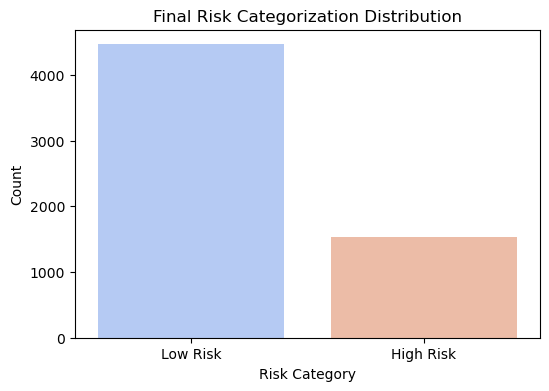

In [67]:
# Visualizing the final risk categories
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (6, 4))
sns.countplot(x = risk_predictions_df["Final Risk Category"], palette = "coolwarm", hue = risk_predictions_df["Final Risk Category"], legend = False)
plt.xlabel("Risk Category")
plt.ylabel("Count")
plt.title("Final Risk Categorization Distribution")
plt.show()